### Import libraries and define random seed

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import random
import math
import os
import zipfile
import shutil
import statistics

from tqdm.auto import tqdm
import itertools

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, f1_score, precision_recall_curve, auc
from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.optim import lr_scheduler

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
# Define a Random Seed for reproducability
RANDOM_SEED = 26
random.seed(RANDOM_SEED)

In [4]:
# Perform cross-validated predictions for AUC calculation
def auc_and_accuracy_scores(X, y, clf):
  y_probs = cross_val_predict(clf, X, y, cv=5, method="predict_proba")

  # Calculate AUC for each fold
  auc_scores = []
  acc_scores =[]
  kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

  for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Compute precision-recall pairs for the current class
    precision, recall, thresholds = precision_recall_curve(y[test_index], y_probs[test_index, 1]) # Use only the test set for this iteration

    # Calculate AUC for Precision-Recall curve
    auc_score = auc(recall, precision)
    auc_scores.append(auc_score)
    print(f"AUC for fold {i + 1}: {auc_score:.4f}")

    # Calculate accuracy
    accuracy = accuracy_score(y[test_index], np.argmax(y_probs[test_index], axis=1))
    acc_scores.append(accuracy)
    print(f"Accuracy for fold {i + 1}: {accuracy:.4f}\n")

  # Print the mean AUC score and accuracy
  print(f"Mean AUC score: {np.mean(auc_scores):.5f}")
  print(f"Mean accuracy score: {np.mean(acc_scores)*100:.4f}%")

In [5]:
# Perform cross-validated predictions for AUC calculation
def auc_and_accuracy_scores_stratified(X, y, clf):
  # Define the StratifiedKFold
  stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
  y_probs = cross_val_predict(clf, X, y, cv=stratified_kfold, method="predict_proba")

  # Calculate AUC for each fold
  auc_scores = []
  acc_scores =[]

  for i, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    # Compute precision-recall pairs for the current class
    precision, recall, thresholds = precision_recall_curve(y[test_index], y_probs[test_index, 1]) # Use only the test set for this iteration

    # Calculate AUC for Precision-Recall curve
    auc_score = auc(recall, precision)
    auc_scores.append(auc_score)
    print(f"AUC for fold {i + 1}: {auc_score:.4f}")

    # Calculate accuracy
    accuracy = accuracy_score(y[test_index], np.argmax(y_probs[test_index], axis=1))
    acc_scores.append(accuracy)
    print(f"Accuracy for fold {i + 1}: {accuracy:.4f}\n")

  # Print the mean AUC score and accuracy
  print(f"Mean AUC score: {np.mean(auc_scores):.5f}")
  print(f"Mean accuracy score: {np.mean(acc_scores)*100:.4f}%")

### Load and unzip datasets

Πρέπει να κάνουμε upload το αρχείο Data Τελικής Εργασίας.zip στο colab.

In [6]:
# Delete 'Data Τελικής Εργασίας' folder
# os.chdir("/content/")
# shutil.rmtree('Data Τελικής Εργασίας')

In [7]:
# List the contents of the /contents directory
target_directory = "/content"
contents = os.listdir(target_directory)
print(f"Contents are: {contents}")

Contents are: ['.config', 'Data Τελικής Εργασίας.zip', 'sample_data']


In [8]:
# Specify the path of the zip file
zip_file_path = "/content/Data Τελικής Εργασίας.zip"

# Specify the test directory for extraction
test_directory = "/content/Data Τελικής Εργασίας.zip/Data Τελικής Εργασίας"

# Specify the target directory for extraction
target_directory = "/content"

In [9]:
# Check if the test directory exists
if not os.path.exists(test_directory):
  print(f"Extracting...")

  # Extract the contents of the zip file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_directory)
  print(f"Extraction completed.")

# List the contents of the target directory
contents = os.listdir(target_directory)
print(f"Contents of the directory [{target_directory}] are: {contents}")

Extracting...
Extraction completed.
Contents of the directory [/content] are: ['.config', 'Data Τελικής Εργασίας.zip', 'Data Τελικής Εργασίας', 'sample_data']


In [10]:
# Specify the path of the zip file
zip_file_path = "/content/Data Τελικής Εργασίας/Mask_DB.zip"

# Specify the test directory for extraction
test_directory = "/content/Data Τελικής Εργασίας/with_mask"

# Specify the target directory for extraction
target_directory = "/content/Data Τελικής Εργασίας/Mask_DB"

# Check if the test directory exists
if not os.path.exists(test_directory):
  print(f"Extracting...")

  # Create the target directory
  os.makedirs(target_directory, exist_ok=True)

  # Extract the contents of the zip file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_directory)
  print(f"Extraction completed.")

# List the contents of the target directory
contents = os.listdir(target_directory)
print(f"Contents of the directory [{target_directory}] are: {contents}")

Extracting...
Extraction completed.
Contents of the directory [/content/Data Τελικής Εργασίας/Mask_DB] are: ['with_mask', 'without_mask', 'mask_incorrect_use']


In [11]:
# Specify the path of the zip file
zip_file_path = "/content/Data Τελικής Εργασίας/Data_Receptors.zip"

# Specify the test directory for extraction
test_directory = "/content/Data Τελικής Εργασίας/with_mask"

# Specify the target directory for extraction
target_directory = "/content/Data Τελικής Εργασίας/Data_Receptors"

# Check if the test directory exists
if not os.path.exists(test_directory):
  print(f"Extracting...")

  # Create the target directory
  os.makedirs(target_directory, exist_ok=True)

  # Extract the contents of the zip file
  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_directory)
  print(f"Extraction completed.")

# List the contents of the target directory
contents = os.listdir(target_directory)
print(f"Contents of the directory [{target_directory}] are: {contents}")

Extracting...
Extraction completed.
Contents of the directory [/content/Data Τελικής Εργασίας/Data_Receptors] are: ['Train_Labels.csv', 'Train_Features.csv', 'Test_Features.csv']


## Part 2

### Read data

In [12]:
train_dir = "/content/Data Τελικής Εργασίας/Data_Receptors/Train_Features.csv"
train_labels_dir = "/content/Data Τελικής Εργασίας/Data_Receptors/Train_Labels.csv"
test_dir = "/content/Data Τελικής Εργασίας/Data_Receptors/Test_Features.csv"

df_train = pd.read_csv(train_dir, header=None)
df_labels = pd.read_csv(train_labels_dir, header=None)
labels = df_labels.values.squeeze()

df_test = pd.read_csv(test_dir, header=None)

In [13]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,3463,3464,3465,3466,3467,3468,3469,3470,3471,3472
0,28.406,22.081,0,0,45.633,2.4611,4.9222,45.633,1.2333,4.5185,...,0,0,0,1,0,0,0,0,1,1
1,30.579,22.122,0,3,51.506,2.4802,4.9235,51.506,1.3207,4.5949,...,0,1,0,1,0,0,0,0,1,1
2,29.165,21.984,0,3,48.652,2.4805,4.9240,48.652,1.3149,4.5486,...,0,1,0,1,0,0,0,0,1,1
3,23.201,17.981,0,1,39.309,2.4240,4.8126,39.309,1.3555,4.3224,...,1,0,0,1,0,0,0,0,1,1
4,27.203,21.749,0,1,45.762,2.4490,4.8979,45.762,1.2712,4.4889,...,1,1,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,28.864,22.504,0,2,46.279,2.4765,4.9192,46.279,1.2508,4.5361,...,0,1,0,1,0,0,0,0,1,1
1111,25.841,19.608,0,5,42.933,2.3821,4.7643,42.933,1.2627,4.4279,...,1,0,1,0,0,0,1,0,1,1
1112,30.515,24.155,0,1,48.696,2.4589,4.9128,48.696,1.2486,4.5882,...,1,0,0,1,0,0,0,0,1,1
1113,20.822,16.168,0,4,34.307,2.4124,4.7748,34.307,1.2706,4.2112,...,1,0,0,0,0,0,0,0,1,1


In [14]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,3463,3464,3465,3466,3467,3468,3469,3470,3471,3472
0,18.511,15.781,0,0,30.800,2.4239,4.8121,30.800,1.2833,4.1047,...,1,1,1,0,0,0,0,0,0,1
1,25.549,19.304,0,1,40.823,2.4435,4.8871,40.823,1.2371,4.4082,...,0,0,0,1,0,0,0,0,0,1
2,32.262,24.264,0,1,53.878,2.4624,4.9247,53.878,1.2828,4.6483,...,1,0,0,0,0,0,0,0,1,1
3,24.737,17.792,0,1,42.542,2.4166,4.8333,42.542,1.3294,4.3886,...,0,0,0,1,0,0,0,0,0,1
4,29.117,20.935,0,1,49.035,2.4006,4.7724,49.035,1.3253,4.5426,...,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,26.686,20.687,0,1,44.017,2.4347,4.8693,44.017,1.2576,4.4599,...,0,1,0,1,0,0,0,0,1,1
120,29.784,21.338,0,1,50.777,2.4038,4.8077,50.777,1.3362,4.5681,...,1,0,0,0,0,0,0,0,1,1
121,29.095,22.515,0,1,47.139,2.4354,4.8708,47.139,1.2405,4.5406,...,0,0,0,1,0,0,0,0,1,1
122,29.784,21.338,0,1,50.777,2.4038,4.8077,50.777,1.3362,4.5681,...,1,0,0,1,0,0,0,0,1,1


In [15]:
X_original, y_original = df_train.values, labels
X_test_original = df_test.values

#### Remove useless features

In [16]:
X_combined_df = pd.concat([df_train, df_test], axis=0, ignore_index=True)
X_combined_df

,0,1,2,3,4,5,6,7,8,9,...,3463,3464,3465,3466,3467,3468,3469,3470,3471,3472
0,28.406,22.081,0,0,45.633,2.4611,4.9222,45.633,1.2333,4.5185,...,0,0,0,1,0,0,0,0,1,1
1,30.579,22.122,0,3,51.506,2.4802,4.9235,51.506,1.3207,4.5949,...,0,1,0,1,0,0,0,0,1,1
2,29.165,21.984,0,3,48.652,2.4805,4.9240,48.652,1.3149,4.5486,...,0,1,0,1,0,0,0,0,1,1
3,23.201,17.981,0,1,39.309,2.4240,4.8126,39.309,1.3555,4.3224,...,1,0,0,1,0,0,0,0,1,1
4,27.203,21.749,0,1,45.762,2.4490,4.8979,45.762,1.2712,4.4889,...,1,1,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,26.686,20.687,0,1,44.017,2.4347,4.8693,44.017,1.2576,4.4599,...,0,1,0,1,0,0,0,0,1,1
1235,29.784,21.338,0,1,50.777,2.4038,4.8077,50.777,1.3362,4.5681,...,1,0,0,0,0,0,0,0,1,1
1236,29.095,22.515,0,1,47.139,2.4354,4.8708,47.139,1.2405,4.5406,...,0,0,0,1,0,0,0,0,1,1
1237,29.784,21.338,0,1,50.777,2.4038,4.8077,50.777,1.3362,4.5681,...,1,0,0,1,0,0,0,0,1,1


In [17]:
count = 0
for column in X_combined_df.columns:
    unique_values = X_combined_df[column].unique()
    # print(f"Column '{column}' has {len(unique_values)}")

    if len(unique_values) == 1:
      count += 1
print("Number of features with only one unique value is:", count)

Number of features with only one unique value is: 197


In [18]:
cont_num = 1425
binary_num = 2048

count_cont = 0
for column in X_combined_df.columns[0:cont_num]:
    unique_values = X_combined_df[column].unique()
    # print(f"Column '{column}' has {len(unique_values)}")

    if len(unique_values) == 1:
      count_cont += 1
print("Number of features with only one unique value is:", count_cont)

count_bin = 0
for column in X_combined_df.columns[cont_num:]:
    unique_values = X_combined_df[column].unique()
    # print(f"Column '{column}' has {len(unique_values)}")

    if len(unique_values) == 1:
      count_bin += 1
print("Number of features with only one unique value is:", count_bin)

Number of features with only one unique value is: 184
Number of features with only one unique value is: 13


In [19]:
# Drop columns with only one unique value
X_combined_df = X_combined_df.loc[:, X_combined_df.nunique() > 1]

In [20]:
X_combined_df

,0,1,2,3,4,5,6,7,8,9,...,3463,3464,3465,3466,3467,3468,3469,3470,3471,3472
0,28.406,22.081,0,0,45.633,2.4611,4.9222,45.633,1.2333,4.5185,...,0,0,0,1,0,0,0,0,1,1
1,30.579,22.122,0,3,51.506,2.4802,4.9235,51.506,1.3207,4.5949,...,0,1,0,1,0,0,0,0,1,1
2,29.165,21.984,0,3,48.652,2.4805,4.9240,48.652,1.3149,4.5486,...,0,1,0,1,0,0,0,0,1,1
3,23.201,17.981,0,1,39.309,2.4240,4.8126,39.309,1.3555,4.3224,...,1,0,0,1,0,0,0,0,1,1
4,27.203,21.749,0,1,45.762,2.4490,4.8979,45.762,1.2712,4.4889,...,1,1,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,26.686,20.687,0,1,44.017,2.4347,4.8693,44.017,1.2576,4.4599,...,0,1,0,1,0,0,0,0,1,1
1235,29.784,21.338,0,1,50.777,2.4038,4.8077,50.777,1.3362,4.5681,...,1,0,0,0,0,0,0,0,1,1
1236,29.095,22.515,0,1,47.139,2.4354,4.8708,47.139,1.2405,4.5406,...,0,0,0,1,0,0,0,0,1,1
1237,29.784,21.338,0,1,50.777,2.4038,4.8077,50.777,1.3362,4.5681,...,1,0,0,1,0,0,0,0,1,1


In [21]:
# Extract the first 1115 rows, training samples
df_train = pd.DataFrame(X_combined_df[:1115])

In [22]:
df_train

,0,1,2,3,4,5,6,7,8,9,...,3463,3464,3465,3466,3467,3468,3469,3470,3471,3472
0,28.406,22.081,0,0,45.633,2.4611,4.9222,45.633,1.2333,4.5185,...,0,0,0,1,0,0,0,0,1,1
1,30.579,22.122,0,3,51.506,2.4802,4.9235,51.506,1.3207,4.5949,...,0,1,0,1,0,0,0,0,1,1
2,29.165,21.984,0,3,48.652,2.4805,4.9240,48.652,1.3149,4.5486,...,0,1,0,1,0,0,0,0,1,1
3,23.201,17.981,0,1,39.309,2.4240,4.8126,39.309,1.3555,4.3224,...,1,0,0,1,0,0,0,0,1,1
4,27.203,21.749,0,1,45.762,2.4490,4.8979,45.762,1.2712,4.4889,...,1,1,0,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,28.864,22.504,0,2,46.279,2.4765,4.9192,46.279,1.2508,4.5361,...,0,1,0,1,0,0,0,0,1,1
1111,25.841,19.608,0,5,42.933,2.3821,4.7643,42.933,1.2627,4.4279,...,1,0,1,0,0,0,1,0,1,1
1112,30.515,24.155,0,1,48.696,2.4589,4.9128,48.696,1.2486,4.5882,...,1,0,0,1,0,0,0,0,1,1
1113,20.822,16.168,0,4,34.307,2.4124,4.7748,34.307,1.2706,4.2112,...,1,0,0,0,0,0,0,0,1,1


In [23]:
# Extract the last rows, test samples
df_test = pd.DataFrame(X_combined_df[1115:])

In [24]:
df_test

,0,1,2,3,4,5,6,7,8,9,...,3463,3464,3465,3466,3467,3468,3469,3470,3471,3472
1115,18.511,15.781,0,0,30.800,2.4239,4.8121,30.800,1.2833,4.1047,...,1,1,1,0,0,0,0,0,0,1
1116,25.549,19.304,0,1,40.823,2.4435,4.8871,40.823,1.2371,4.4082,...,0,0,0,1,0,0,0,0,0,1
1117,32.262,24.264,0,1,53.878,2.4624,4.9247,53.878,1.2828,4.6483,...,1,0,0,0,0,0,0,0,1,1
1118,24.737,17.792,0,1,42.542,2.4166,4.8333,42.542,1.3294,4.3886,...,0,0,0,1,0,0,0,0,0,1
1119,29.117,20.935,0,1,49.035,2.4006,4.7724,49.035,1.3253,4.5426,...,1,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,26.686,20.687,0,1,44.017,2.4347,4.8693,44.017,1.2576,4.4599,...,0,1,0,1,0,0,0,0,1,1
1235,29.784,21.338,0,1,50.777,2.4038,4.8077,50.777,1.3362,4.5681,...,1,0,0,0,0,0,0,0,1,1
1236,29.095,22.515,0,1,47.139,2.4354,4.8708,47.139,1.2405,4.5406,...,0,0,0,1,0,0,0,0,1,1
1237,29.784,21.338,0,1,50.777,2.4038,4.8077,50.777,1.3362,4.5681,...,1,0,0,1,0,0,0,0,1,1


In [25]:
X, y = df_train.values, labels
X_test = df_test.values

#### Explore classes

In [26]:
print(labels)
print(labels.shape)

[1 1 1 ... 1 0 1]
(1115,)


In [27]:
print(f"Number of data with label 0 is: {list(labels).count(0)}")
print(f"Number of data with label 1 is: {list(labels).count(1)}")

Number of data with label 0 is: 374
Number of data with label 1 is: 741


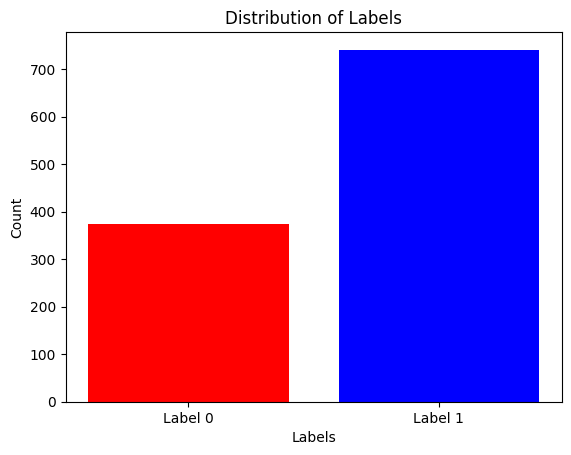

In [28]:
# Count the occurrences of labels 0 and 1
count_label_0 = list(labels).count(0)
count_label_1 = list(labels).count(1)

# Create a bar diagram
labels_list = ['Label 0', 'Label 1']
counts = [count_label_0, count_label_1]

plt.bar(labels_list, counts, color=['red', 'blue'])
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.show()

### Try different classifiers

#### Decision Tree

In [ ]:
# Tree
tree = DecisionTreeClassifier(random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(tree, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.87892377 0.89237668 0.90134529 0.91479821 0.85650224]
Mean CV accuracy: 88.8789%


In [ ]:
# Tree, F1 Score
tree = DecisionTreeClassifier(random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(tree, X, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.909699   0.91724138 0.9261745  0.93559322 0.89333333]
Mean CV F1 score: 0.9164


#### Random Forest

In [ ]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(random_forest, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.88340807 0.92376682 0.91479821 0.91479821 0.88789238]
Mean CV accuracy: 90.4933%


In [ ]:
# Random Forest, F1 Score
random_forest = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(random_forest, X, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.91612903 0.9442623  0.93890675 0.93890675 0.92113565]
Mean CV F1 score: 0.9319


In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 7, 10]
}

# Create the combinations of hyperparameters
param_combinations = list(itertools.product(*param_grid.values()))
# Total number of combinations
total_combinations = len(param_combinations)

# Create a Random Forest classifier
random_forest = RandomForestClassifier(random_state=RANDOM_SEED)
# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search with tqdm progress bar
for param_combination in tqdm(param_combinations, desc="Grid Search Progress"):
  params = dict(zip(param_grid.keys(), param_combination))

  # Update the parameters of the RandomForestClassifier within the GridSearchCV
  random_forest.set_params(**params)

  # Set the updated RandomForestClassifier as the estimator for the GridSearchCV
  grid_search.estimator = random_forest

  # Fit the GridSearchCV with the updated estimator
  grid_search.fit(X, y)

Grid Search Progress:   0%|          | 0/12 [00:00<?, ?it/s]

In [ ]:
# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Train a new Random Forest model with the best parameters
best_random_forest = RandomForestClassifier(n_estimators=best_params['n_estimators'],
                                            max_depth=best_params['max_depth'],
                                            random_state=RANDOM_SEED)

print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 10, 'n_estimators': 300}


In [ ]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(random_forest, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.88340807 0.91928251 0.92825112 0.93273543 0.89686099]
Mean CV accuracy: 91.2108%


In [ ]:
# Random Forest, F1 Score
random_forest = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(random_forest, X, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.91447368 0.94117647 0.94805195 0.95114007 0.92698413]
Mean CV F1 score: 0.9364


#### AdaBoost

In [ ]:
# Adaboost
adaboost = AdaBoostClassifier(n_estimators=100, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(adaboost, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.87892377 0.90134529 0.92376682 0.9103139  0.90134529]
Mean CV accuracy: 90.3139%


In [ ]:
# Adaboost
base_classifier = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=RANDOM_SEED)
adaboost = AdaBoostClassifier(base_classifier, n_estimators=100, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(adaboost, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.89237668 0.93273543 0.92376682 0.93721973 0.91479821]
Mean CV accuracy: 92.0179%


In [ ]:
# Adaboost, F1-score
base_classifier = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=RANDOM_SEED)
adaboost = AdaBoostClassifier(base_classifier, n_estimators=100, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(adaboost, X, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.91946309 0.95081967 0.94533762 0.95424837 0.93890675]
Mean CV F1 score: 0.9418


#### XGBoost

In [ ]:
# XGBoost
xgboost = XGBClassifier(n_estimators=50, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(xgboost, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.88789238 0.94170404 0.92825112 0.93721973 0.92825112]
Mean CV accuracy: 92.4664%


In [ ]:
# XGBoost, F1 Score
xgboost = XGBClassifier(n_estimators=50, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1) # max_depth=6 default

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(xgboost, X, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.91694352 0.95709571 0.94771242 0.95333333 0.9483871 ]
Mean CV F1 score: 0.9447


In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10],
}

# Create the combinations of hyperparameters
param_combinations = list(itertools.product(*param_grid.values()))
# Total number of combinations
total_combinations = len(param_combinations)

# Create an XGBoost classifier
xgboost = XGBClassifier(random_state=RANDOM_SEED, n_jobs=-1)
# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=xgboost, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform the grid search with tqdm progress bar
for param_combination in tqdm(param_combinations, desc="Grid Search Progress"):
  params = dict(zip(param_grid.keys(), param_combination))

  # Update the parameters of the RandomForestClassifier within the GridSearchCV
  xgboost.set_params(**params)

  # Set the updated RandomForestClassifier as the estimator for the GridSearchCV
  grid_search.estimator = xgboost

  # Fit the GridSearchCV with the updated estimator
  grid_search.fit(X, y)

Grid Search Progress:   0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
# Get the best parameters from the grid search
best_params = grid_search.best_params_

# Train a new Random Forest model with the best parameters
best_xgboost = XGBClassifier(n_estimators=best_params['n_estimators'],
                             max_depth=best_params['max_depth'],
                             random_state=RANDOM_SEED)

print("Best Parameters:", best_params)

Best Parameters: {'max_depth': 6, 'n_estimators': 200}


In [ ]:
# XGBoost
xgboost = XGBClassifier(n_estimators=200, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(xgboost, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.88340807 0.94170404 0.93273543 0.94618834 0.92825112]
Mean CV accuracy: 92.6457%


In [ ]:
# XGBoost, F1 Score
xgboost = XGBClassifier(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1) # max_depth=6 default

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(xgboost, X, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.91333333 0.95709571 0.95049505 0.96       0.9483871 ]
Mean CV F1 score: 0.9459


### RandomForest Tuning more the hyperparameters

In [ ]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(random_forest, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.88340807 0.92376682 0.93721973 0.93721973 0.90134529]
Mean CV accuracy: 91.6592%


In [ ]:
# Random Forest, F1 Score
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(random_forest, X, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.91333333 0.9442623  0.95424837 0.95424837 0.92993631]
Mean CV F1 score: 0.9392


In [ ]:
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)
auc_and_accuracy_scores(X, y, random_forest)

AUC for fold 1: 0.9706
Accuracy for fold 1: 0.9013

AUC for fold 2: 0.9783
Accuracy for fold 2: 0.9058

AUC for fold 3: 0.9821
Accuracy for fold 3: 0.9193

AUC for fold 4: 0.9792
Accuracy for fold 4: 0.9283

AUC for fold 5: 0.9835
Accuracy for fold 5: 0.9283

Mean AUC score: 0.97875
Mean accuracy score: 91.6592%


### XGBoost Tuning more the hyperparameters

In [ ]:
# XGBoost
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(xgboost, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.88340807 0.94618834 0.93273543 0.94618834 0.93273543]
Mean CV accuracy: 92.8251%


In [ ]:
# XGBoost, F1 Score
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(xgboost, X, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.91333333 0.9602649  0.95049505 0.96       0.95145631]
Mean CV F1 score: 0.9471


In [ ]:
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)
auc_and_accuracy_scores(X, y, xgboost)

AUC for fold 1: 0.9708
Accuracy for fold 1: 0.9103

AUC for fold 2: 0.9822
Accuracy for fold 2: 0.9193

AUC for fold 3: 0.9861
Accuracy for fold 3: 0.9327

AUC for fold 4: 0.9856
Accuracy for fold 4: 0.9372

AUC for fold 5: 0.9887
Accuracy for fold 5: 0.9417

Mean AUC score: 0.98268
Mean accuracy score: 92.8251%


### XGBoost Less weight to positive class

In [ ]:
# Define the XGBoost classifier
xgboost = XGBClassifier(n_estimators=275, max_depth=6, scale_pos_weight=0.5, random_state=RANDOM_SEED, n_jobs=-1) # default scale_pos_weight = 1

# Define the StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds using stratified k-fold
cv_scores = cross_val_score(xgboost, X, y, cv=stratified_kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.9103139  0.92376682 0.93273543 0.92825112 0.91928251]
Mean CV accuracy: 92.2870%


In [ ]:
# Define the XGBoost classifier
xgboost = XGBClassifier(n_estimators=275, max_depth=6, scale_pos_weight=0.5, random_state=RANDOM_SEED, n_jobs=-1)

# Define the StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(xgboost, X, y, scoring=f1_scorer, cv=stratified_kfold)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.93421053 0.94352159 0.94809689 0.94701987 0.94117647]
Mean CV F1 score: 0.9428


In [ ]:
# Define the XGBoost classifier
xgboost = XGBClassifier(n_estimators=275, max_depth=6, scale_pos_weight=0.75, random_state=RANDOM_SEED, n_jobs=-1)

# Define the StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds using stratified k-fold
cv_scores = cross_val_score(xgboost, X, y, cv=stratified_kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.92376682 0.92376682 0.95515695 0.92376682 0.9103139 ]
Mean CV accuracy: 92.7354%


In [ ]:
# Define the XGBoost classifier
xgboost = XGBClassifier(n_estimators=275, max_depth=6, scale_pos_weight=0.75, random_state=RANDOM_SEED, n_jobs=-1)

# Define the StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(xgboost, X, y, scoring=f1_scorer, cv=stratified_kfold)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.94462541 0.94389439 0.96598639 0.9442623  0.93421053]
Mean CV F1 score: 0.9466


In [ ]:
# Define the XGBoost classifier
xgboost = XGBClassifier(n_estimators=275, max_depth=6, scale_pos_weight=0.95, random_state=RANDOM_SEED, n_jobs=-1)

# Define the StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds using stratified k-fold
cv_scores = cross_val_score(xgboost, X, y, cv=stratified_kfold)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.91479821 0.93721973 0.94618834 0.92825112 0.91928251]
Mean CV accuracy: 92.9148%


In [ ]:
# Define the XGBoost classifier
xgboost = XGBClassifier(n_estimators=275, max_depth=6, scale_pos_weight=0.95, random_state=RANDOM_SEED, n_jobs=-1)

# Define the StratifiedKFold
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(xgboost, X, y, scoring=f1_scorer, cv=stratified_kfold)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.93811075 0.95364238 0.95945946 0.94771242 0.94117647]
Mean CV F1 score: 0.9480


In [ ]:
xgboost = XGBClassifier(n_estimators=275, max_depth=6, scale_pos_weight=0.95, random_state=RANDOM_SEED, n_jobs=-1)
auc_and_accuracy_scores_stratified(X, y, xgboost)

AUC for fold 1: 0.9627
Accuracy for fold 1: 0.9148

AUC for fold 2: 0.9820
Accuracy for fold 2: 0.9372

AUC for fold 3: 0.9939
Accuracy for fold 3: 0.9462

AUC for fold 4: 0.9889
Accuracy for fold 4: 0.9283

AUC for fold 5: 0.9765
Accuracy for fold 5: 0.9193

Mean AUC score: 0.98080
Mean accuracy score: 92.9148%


### Dimensionality Reduction

#### PCA

##### On all features

In [ ]:
X.shape

(1115, 3276)

In [ ]:
X_continuous = X[:, 0:1241] # 1425-184
X_binary = X[:, 1241:]

# Standardize only continuous features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_continuous)
X_standardized.shape

(1115, 1241)

In [ ]:
X_combined = np.concatenate((X_standardized, X_binary), axis=1)
X_combined.shape

(1115, 3276)

In [ ]:
# Perform PCA on the dataset
pca = PCA() # If n_components is not set all components are kept
x_pca = pca.fit_transform(X_combined) # Fit the model with x_data and apply the dimensionality reduction on x_data

# Percentage of variance explained by each of the selected components
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio is:\n{explained_variance_ratio}")

# Percentage of the cumulative explained variance ratio, total variance explaied by component n and all the previous components
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print(f"Cumulative Explained Variance Ratio is:\n{cumulative_explained_variance}")

# Find the index of which component can achieve cumulative variance >= 90%, + 1 because list index starts from 0
min_components_90 = np.argmax(cumulative_explained_variance >= 0.9) + 1
# Find the index of which component can achieve cumulative variance >= 99%, + 1 because list index starts from 0
min_components_99 = np.argmax(cumulative_explained_variance >= 0.99) + 1

print(f"To explain 90% of the variance we need at least {min_components_90} principal components.")
print(f"To explain 99% of the variance we need at least {min_components_99} principal components.")

Explained Variance Ratio is:
[2.30620573e-01 1.26420990e-01 8.05613948e-02 ... 1.24079586e-33
 5.20306798e-34 4.92629194e-34]
Cumulative Explained Variance Ratio is:
[0.23062057 0.35704156 0.43760296 ... 1.         1.         1.        ]
To explain 90% of the variance we need at least 47 principal components.
To explain 99% of the variance we need at least 260 principal components.


In [ ]:
# Apply PCA
n_components = 260  # Number of components, the maximum number is min(features, samples)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_combined) # X_combined (n_samples, n_features)

# Create a new DataFrame with the PCA components
X_pca.shape

(1115, 260)

In [ ]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(random_forest, X_pca, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.88340807 0.9103139  0.89686099 0.91479821 0.90134529]
Mean CV accuracy: 90.1345%


In [ ]:
# Random Forest, F1 Score
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(random_forest, X_pca, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.91612903 0.93506494 0.92744479 0.93890675 0.93037975]
Mean CV F1 score: 0.9296


In [ ]:
# XGBoost
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(xgboost, X_pca, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.89686099 0.92376682 0.9058296  0.9058296  0.9058296 ]
Mean CV accuracy: 90.7623%


In [ ]:
# XGBoost, F1 Score
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(xgboost, X_pca, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.92307692 0.94389439 0.93114754 0.93159609 0.93203883]
Mean CV F1 score: 0.9324


##### Only on continuous features

In [ ]:
X.shape

(1115, 3276)

In [ ]:
X_continuous = X[:, 0:1241] # 1425-184
X_binary = X[:, 1241:]

# Standardize only constant features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_continuous)
X_standardized.shape

(1115, 1241)

In [ ]:
# Perform PCA on the dataset
pca = PCA() # If n_components is not set all components are kept
x_pca = pca.fit_transform(X_standardized) # Fit the model with x_data and apply the dimensionality reduction on x_data

# Percentage of variance explained by each of the selected components
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio is:\n{explained_variance_ratio}")

# Percentage of the cumulative explained variance ratio, total variance explaied by component n and all the previous components
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
print(f"Cumulative Explained Variance Ratio is:\n{cumulative_explained_variance}")

# Find the index of which component can achieve cumulative variance >= 90%, + 1 because list index starts from 0
min_components_90 = np.argmax(cumulative_explained_variance >= 0.9) + 1
# Find the index of which component can achieve cumulative variance >= 99%, + 1 because list index starts from 0
min_components_99 = np.argmax(cumulative_explained_variance >= 0.99) + 1

print(f"To explain 90% of the variance we need at least {min_components_90} principal components.")
print(f"To explain 99% of the variance we need at least {min_components_99} principal components.")

Explained Variance Ratio is:
[2.78423416e-01 1.40632495e-01 9.02391163e-02 ... 1.63312985e-33
 1.63312985e-33 7.91538110e-34]
Cumulative Explained Variance Ratio is:
[0.27842342 0.41905591 0.50929503 ... 1.         1.         1.        ]
To explain 90% of the variance we need at least 27 principal components.
To explain 99% of the variance we need at least 97 principal components.


In [ ]:
# Apply PCA
n_components = 97  # Number of components, the maximum number is min(features, samples)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_standardized) # X_combined (n_samples, n_features)

# Create a new DataFrame with the PCA components
X_pca.shape

(1115, 97)

In [ ]:
X_combined = np.concatenate((X_pca, X_binary), axis=1)
X_combined.shape

(1115, 2132)

In [ ]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(random_forest, X_combined, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.91928251 0.93721973 0.93721973 0.9103139  0.91928251]
Mean CV accuracy: 92.4664%


In [ ]:
# Random Forest, F1 Score
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(random_forest, X_combined, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.94       0.95394737 0.95424837 0.93548387 0.94230769]
Mean CV F1 score: 0.9452


In [ ]:
# XGBoost
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(xgboost, X_combined, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.87892377 0.92825112 0.92376682 0.9103139  0.91928251]
Mean CV accuracy: 91.2108%


In [ ]:
# XGBoost, F1 Score
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(xgboost, X_combined, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.909699   0.94771242 0.94462541 0.93506494 0.94193548]
Mean CV F1 score: 0.9358


#### Autoencoder

##### On binary features

In [ ]:
X.shape

(1115, 3276)

In [ ]:
X_binary = X[:, 1241:] # 1425-184

In [ ]:
X_binary.shape

(1115, 2035)

In [ ]:
X_continuous = X[:, 0:1241] # 1425-184

# Standardize only continuous features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_continuous)
X_standardized.shape

(1115, 1241)

In [ ]:
X_combined = np.concatenate((X_standardized, X_binary), axis=1)
X_combined.shape

(1115, 3276)

In [ ]:
X_tensor = torch.FloatTensor(X_binary)
y_tensor = torch.LongTensor(y)

batch_size = 32

dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
print(f"Number of batches is {len(dataloader)}")

Number of batches is 35


In [ ]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the autoencoder architecture separately in order to easily retrieve latent representations
class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 1500),
            nn.ReLU(),
            nn.Linear(1500, latent_size)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 1500),
            nn.ReLU(),
            nn.Linear(1500, input_size),
            nn.Sigmoid()
        )

    # Define forward pass as an encoding followed by decoding
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Hyperparameters
input_size = 2035
latent_size = 1200
learning_rate = 0.001
num_epochs = 35

# Initialize the autoencoder
model1 = Autoencoder(input_size, latent_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss() # MSE is the standard reconstruction-oriented loss
optimizer = optim.Adam(model1.parameters(), lr=learning_rate)

scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)

# Training the autoencoder
for epoch in range(num_epochs):
    for data in dataloader:
        inputs, _ = data
        inputs = inputs.to(device)

        # Forward pass
        output = model1(inputs)

        # Compute the loss
        loss = criterion(output, inputs)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()

    # Print the loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/35], Loss: 0.0837
Epoch [2/35], Loss: 0.0782
Epoch [3/35], Loss: 0.0494
Epoch [4/35], Loss: 0.0599
Epoch [5/35], Loss: 0.0469
Epoch [6/35], Loss: 0.0331
Epoch [7/35], Loss: 0.0359
Epoch [8/35], Loss: 0.0371
Epoch [9/35], Loss: 0.0271
Epoch [10/35], Loss: 0.0267
Epoch [11/35], Loss: 0.0201
Epoch [12/35], Loss: 0.0218
Epoch [13/35], Loss: 0.0189
Epoch [14/35], Loss: 0.0184
Epoch [15/35], Loss: 0.0198
Epoch [16/35], Loss: 0.0177
Epoch [17/35], Loss: 0.0155
Epoch [18/35], Loss: 0.0121
Epoch [19/35], Loss: 0.0120
Epoch [20/35], Loss: 0.0119
Epoch [21/35], Loss: 0.0114
Epoch [22/35], Loss: 0.0090
Epoch [23/35], Loss: 0.0110
Epoch [24/35], Loss: 0.0106
Epoch [25/35], Loss: 0.0090
Epoch [26/35], Loss: 0.0088
Epoch [27/35], Loss: 0.0089
Epoch [28/35], Loss: 0.0102
Epoch [29/35], Loss: 0.0091
Epoch [30/35], Loss: 0.0107
Epoch [31/35], Loss: 0.0074
Epoch [32/35], Loss: 0.0090
Epoch [33/35], Loss: 0.0100
Epoch [34/35], Loss: 0.0113
Epoch [35/35], Loss: 0.0063


##### Encode and make predictions

In [ ]:
# Binary
X_tensor = torch.FloatTensor(X_binary)
y_tensor = torch.LongTensor(y)

batch_size = 32

encoded_list = []

dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

with torch.inference_mode():
    for data in dataloader:
        inputs, labels = data
        inputs = inputs.to(device)

        # Encode the input images
        encoded = model1.encoder(inputs)

        # Convert encoded to NumPy array and append to the list
        encoded_list.append(encoded.cpu().detach().numpy())

# Concatenate the list of NumPy arrays into a single NumPy array
encoded_numpy = np.concatenate(encoded_list, axis=0)

In [ ]:
encoded_numpy.shape

(1115, 1200)

In [ ]:
X_combined = np.concatenate((X_standardized, encoded_numpy), axis=1)
X_combined.shape

(1115, 2441)

In [ ]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(random_forest, X_combined, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.88340807 0.91928251 0.91479821 0.9058296  0.89686099]
Mean CV accuracy: 90.4036%


In [ ]:
# Random Forest, F1 Score
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(random_forest, X_combined, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.91612903 0.94117647 0.93890675 0.93203883 0.92789969]
Mean CV F1 score: 0.9312


In [ ]:
# XGBoost
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(xgboost, X_combined, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.88340807 0.91928251 0.9058296  0.9103139  0.91479821]
Mean CV accuracy: 90.6726%


In [ ]:
# XGBoost, F1 Score
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(xgboost, X_combined, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.91275168 0.94039735 0.93203883 0.93377483 0.93890675]
Mean CV F1 score: 0.9316


#### Autoencoder and PCA

In [ ]:
X_combined = np.concatenate((X_pca, encoded_numpy), axis=1)
X_combined.shape

(1115, 1297)

In [ ]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(random_forest, X_combined, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.79820628 0.8161435  0.78923767 0.79820628 0.78026906]
Mean CV accuracy: 79.6413%


In [ ]:
# Random Forest, F1 Score
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(random_forest, X_combined, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.86646884 0.87461774 0.86217009 0.86322188 0.85630499]
Mean CV F1 score: 0.8646


In [ ]:
# XGBoost
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(xgboost, X_combined, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.87892377 0.89237668 0.9058296  0.88789238 0.85201794]
Mean CV accuracy: 88.3408%


In [ ]:
# XGBoost, F1 Score
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(xgboost, X_combined, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.90728477 0.93114754 0.91823899 0.91147541 0.91318328]
Mean CV F1 score: 0.9163


### Ensembles with XGBoost

In [ ]:
# SVM
X_continuous = X[:, 0:1241] # 1425-184
X_binary = X[:, 1241:]

# Standardize only continuous features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X_continuous)
X_combined = np.concatenate((X_standardized, X_binary), axis=1)

svm_model = SVC(kernel='rbf', random_state=RANDOM_SEED)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(svm_model, X_combined, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.88340807 0.92376682 0.89686099 0.90134529 0.9058296 ]
Mean CV accuracy: 90.2242%


In [ ]:
# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(svm_model, X_combined, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.91447368 0.9442623  0.92744479 0.92903226 0.93247588]
Mean CV F1 score: 0.9295


In [ ]:
# XGBoost, random forest and SVM ensemble, final_estimator = RandomForestClassifier
# Create base models for classification
xgb_model = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)
svm_model = SVC(kernel='rbf', random_state=RANDOM_SEED)
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)


# Create a stacked ensemble using a Logistic Regression meta-learner
stacked_ensemble = StackingClassifier(
    estimators=[('xgb', xgb_model), ('rf', random_forest), ('svm', svm_model)],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(stacked_ensemble, X_combined, y, cv=5, verbose=0)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.88340807 0.93721973 0.91928251 0.93721973 0.92376682]
Mean CV accuracy: 92.0179%


In [ ]:
# Create base models for classification
xgb_model = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)
svm_model = SVC(kernel='rbf', random_state=RANDOM_SEED)
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)


# Create a stacked ensemble using a Logistic Regression meta-learner
stacked_ensemble = StackingClassifier(
    estimators=[('xgb', xgb_model), ('rf', random_forest), ('svm', svm_model)],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED)
)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(stacked_ensemble, X, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.9023569  0.9559322  0.94983278 0.9632107  0.9442623 ]
Mean CV F1 score: 0.9431


In [ ]:
# XGBoost and random forest, final_estimator = LogisticRegression
# Create base models
xgb_model = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)

# Create a stacked ensemble using a Logistic Regression meta-learner
stacked_ensemble = StackingClassifier(
    estimators=[('xgb', xgb_model), ('rf', random_forest)],
    final_estimator=LogisticRegression()
)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(stacked_ensemble, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.88340807 0.94170404 0.93273543 0.94618834 0.92376682]
Mean CV accuracy: 92.5561%


In [ ]:
# Create base models
xgb_model = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)

# Create a stacked ensemble using a Logistic Regression meta-learner
stacked_ensemble = StackingClassifier(
    estimators=[('xgb', xgb_model), ('rf', random_forest)],
    final_estimator=LogisticRegression()
)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(stacked_ensemble, X, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.91333333 0.95681063 0.95081967 0.96       0.94498382]
Mean CV F1 score: 0.9452


In [ ]:
# XGBoost and random forest, final_estimator = GradientBoostingClassifier
# Create base models
xgb_model = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)

# Create a stacked ensemble using a Logistic Regression meta-learner
stacked_ensemble = StackingClassifier(
    estimators=[('xgb', xgb_model), ('rf', random_forest)],
    final_estimator=GradientBoostingClassifier()
)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(stacked_ensemble, X, y, cv=5, verbose=0)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.87892377 0.91928251 0.90134529 0.92825112 0.9103139 ]
Mean CV accuracy: 90.7623%


In [ ]:
# Create base models
xgb_model = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=350, max_depth=12, random_state=RANDOM_SEED)

# Create a stacked ensemble using a Logistic Regression meta-learner
stacked_ensemble = StackingClassifier(
    estimators=[('xgb', xgb_model), ('rf', random_forest)],
    final_estimator=GradientBoostingClassifier()
)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(stacked_ensemble, X, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.90784983 0.93959732 0.92409241 0.94630872 0.93506494]
Mean CV F1 score: 0.9306


### Plots for the best models

#### Best model 92.8251% accuracy

In [ ]:
# Perform cross-validated predictions and plots
def plots(X, y, clf):
  y_probs = cross_val_predict(clf, X, y, cv=5, method="predict_proba")

  # Calculate AUC for each fold
  auc_scores = []
  acc_scores =[]
  kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

  for i, (train_index, test_index) in enumerate(kf.split(X)):
    # Compute precision-recall pairs for the current class
    precision, recall, thresholds = precision_recall_curve(y[test_index], y_probs[test_index, 1]) # Use only the test set for this iteration

    # Calculate AUC for Precision-Recall curve
    auc_score = auc(recall, precision)
    auc_scores.append(auc_score)
    print(f"AUC for fold {i + 1}: {auc_score:.4f}")

    # Calculate accuracy
    accuracy = accuracy_score(y[test_index], np.argmax(y_probs[test_index], axis=1))
    acc_scores.append(accuracy)
    print(f"Accuracy for fold {i + 1}: {accuracy:.4f}\n")

    # Create precision recall plot
    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, label=f'AUC = {auc_score:.2f}', color='blue')
    # Set labels and title
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Plot confusion matrix
    preds = np.round(y_probs[test_index, 1])
    classes = ["0", "1"]
    cm = confusion_matrix(y[test_index], preds)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

  # Print the mean AUC score and accuracy
  print(f"Mean AUC score: {np.mean(auc_scores):.5f}")
  print(f"Mean accuracy score: {np.mean(acc_scores)*100:.4f}%")

AUC for fold 1: 0.9708
Accuracy for fold 1: 0.9103



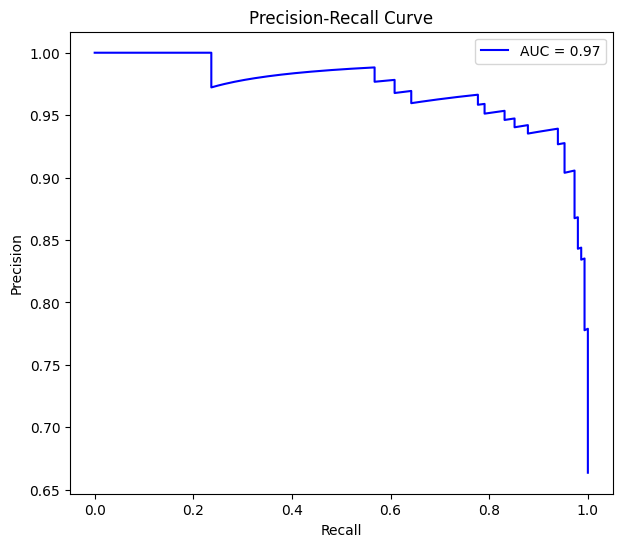

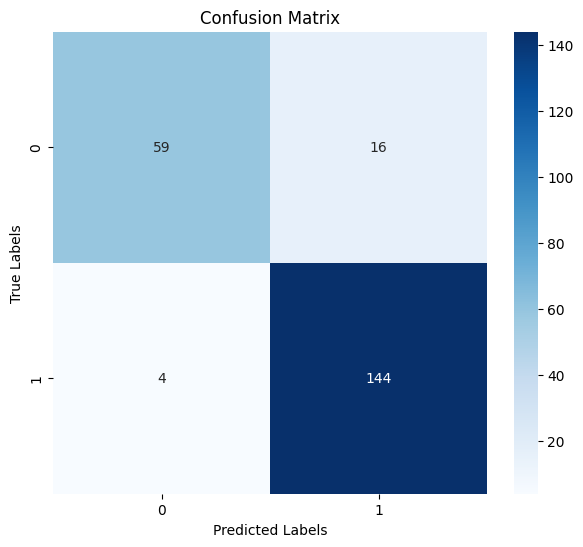

AUC for fold 2: 0.9822
Accuracy for fold 2: 0.9193



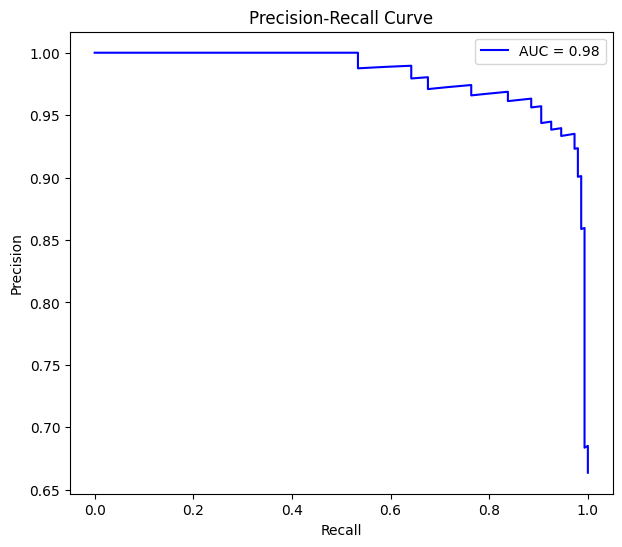

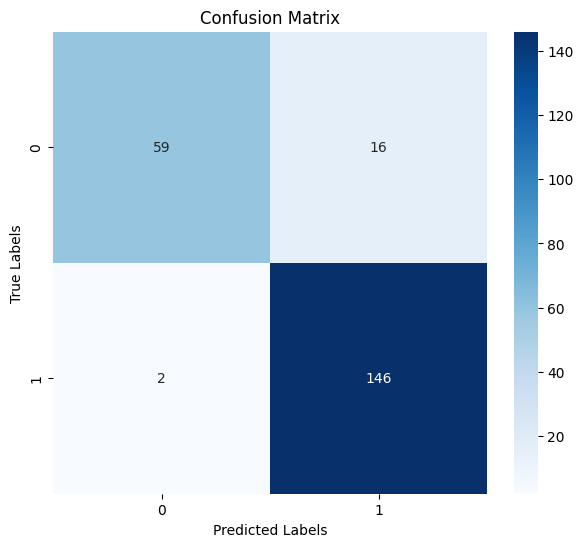

AUC for fold 3: 0.9861
Accuracy for fold 3: 0.9327



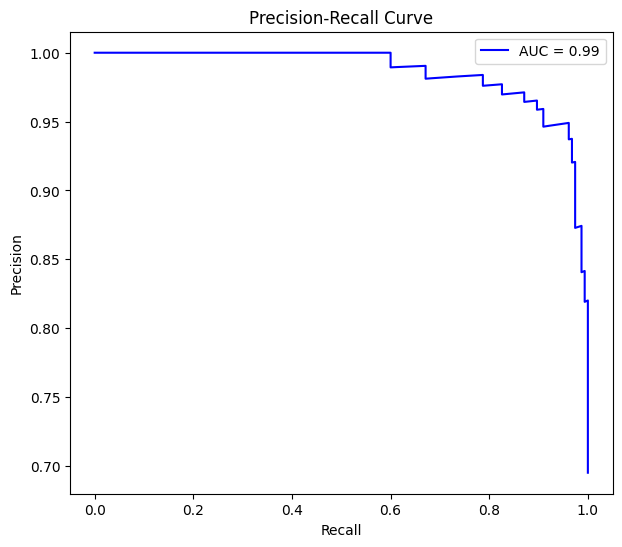

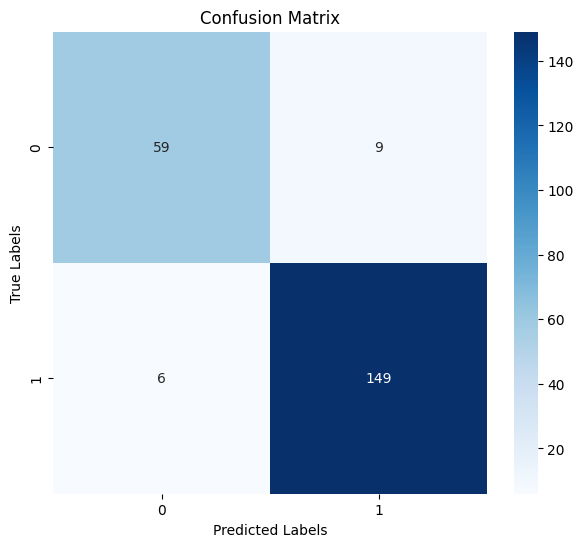

AUC for fold 4: 0.9856
Accuracy for fold 4: 0.9372



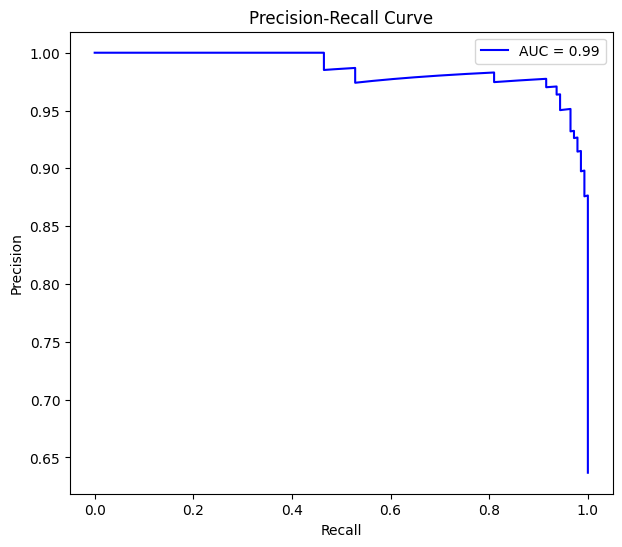

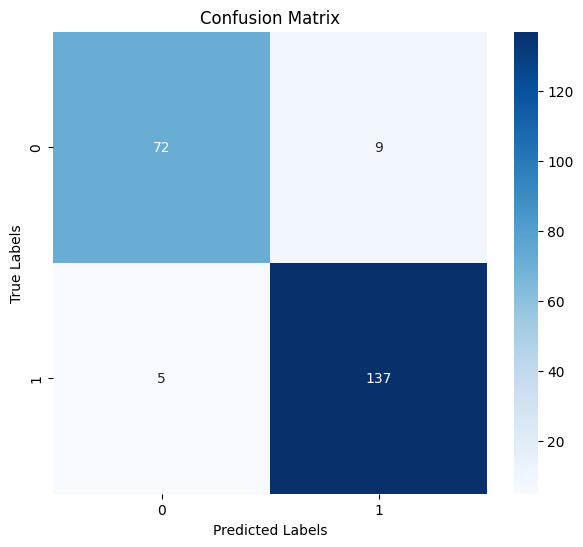

AUC for fold 5: 0.9887
Accuracy for fold 5: 0.9417



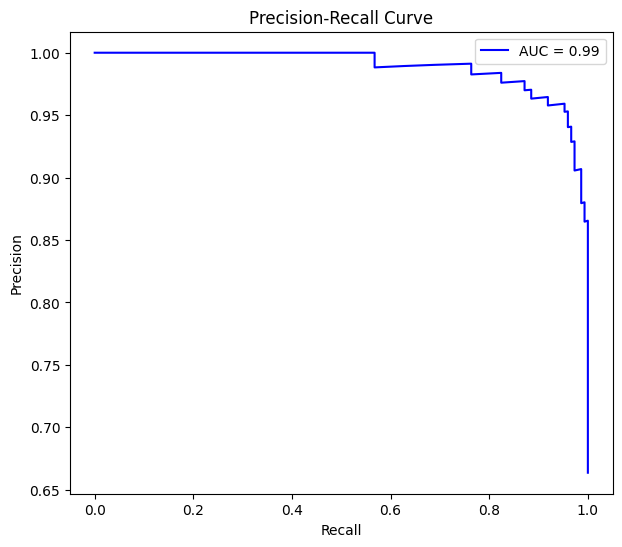

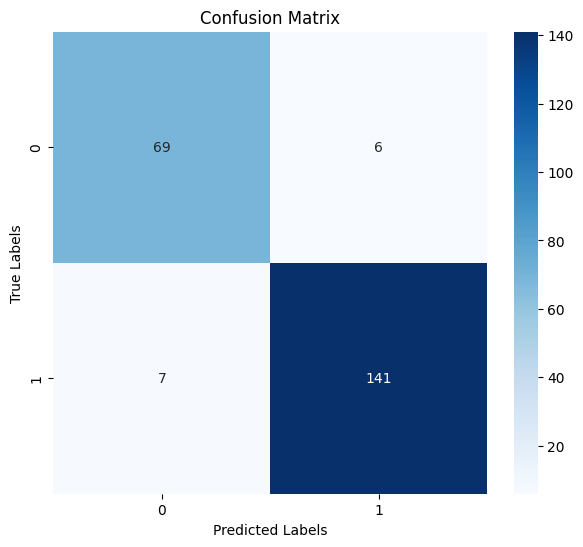

Mean AUC score: 0.98268
Mean accuracy score: 92.8251%


In [ ]:
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)
plots(X, y, xgboost)

#### Best model with less weight to positive class 92.9148% accuracy

In [ ]:
# Perform cross-validated predictions for AUC calculation
def plots_stratified(X, y, clf):
  # Define the StratifiedKFold
  stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
  y_probs = cross_val_predict(clf, X, y, cv=stratified_kfold, method="predict_proba")

  # Calculate AUC for each fold
  auc_scores = []
  acc_scores =[]

  for i, (train_index, test_index) in enumerate(stratified_kfold.split(X, y)):
    # Compute precision-recall pairs for the current class
    precision, recall, thresholds = precision_recall_curve(y[test_index], y_probs[test_index, 1]) # Use only the test set for this iteration

    # Calculate AUC for Precision-Recall curve
    auc_score = auc(recall, precision)
    auc_scores.append(auc_score)
    print(f"AUC for fold {i + 1}: {auc_score:.4f}")

    # Calculate accuracy
    accuracy = accuracy_score(y[test_index], np.argmax(y_probs[test_index], axis=1))
    acc_scores.append(accuracy)
    print(f"Accuracy for fold {i + 1}: {accuracy:.4f}\n")

    # Create precision recall plot
    plt.figure(figsize=(7, 6))
    plt.plot(recall, precision, label=f'AUC = {auc_score:.2f}', color='blue')
    # Set labels and title
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    # Plot confusion matrix
    preds = np.round(y_probs[test_index, 1])
    classes = ["0", "1"]
    cm = confusion_matrix(y[test_index], preds)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

  # Print the mean AUC score and accuracy
  print(f"Mean AUC score: {np.mean(auc_scores):.5f}")
  print(f"Mean accuracy score: {np.mean(acc_scores)*100:.4f}%")

AUC for fold 1: 0.9627
Accuracy for fold 1: 0.9148



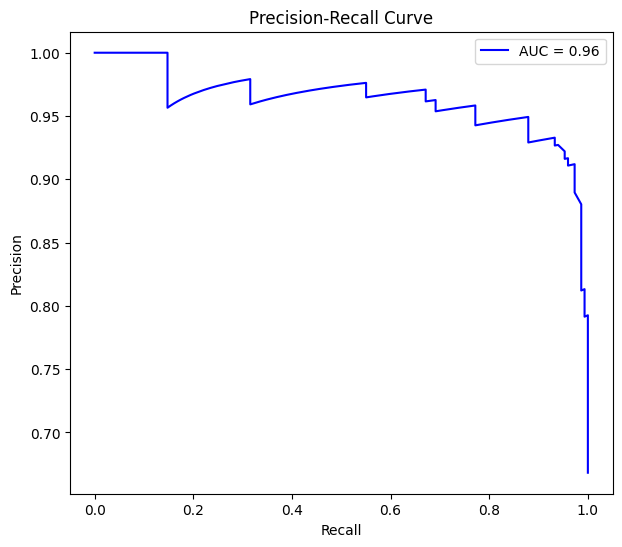

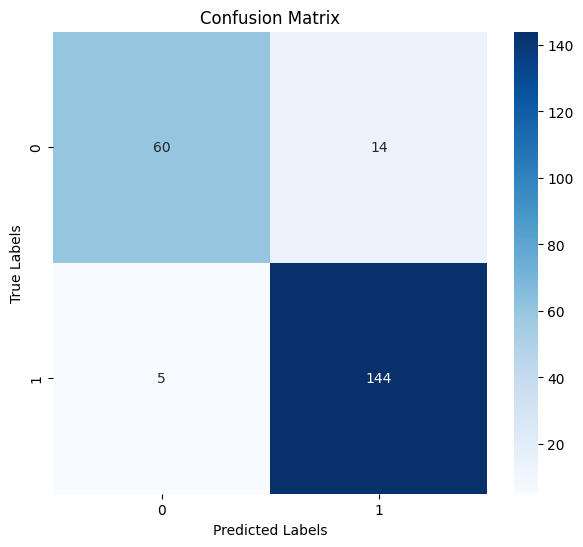

AUC for fold 2: 0.9820
Accuracy for fold 2: 0.9372



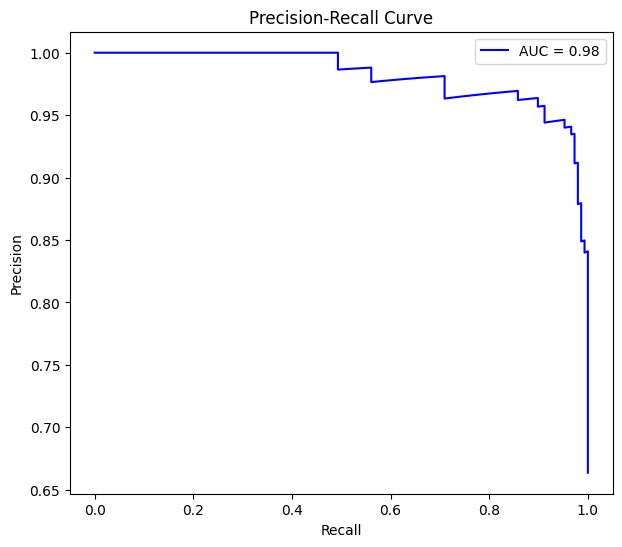

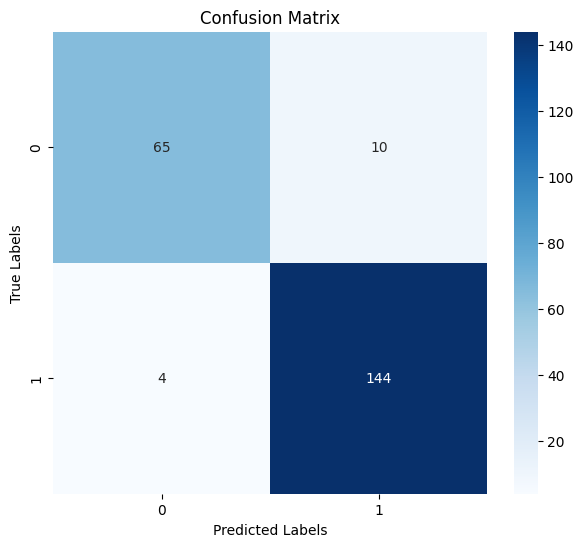

AUC for fold 3: 0.9939
Accuracy for fold 3: 0.9462



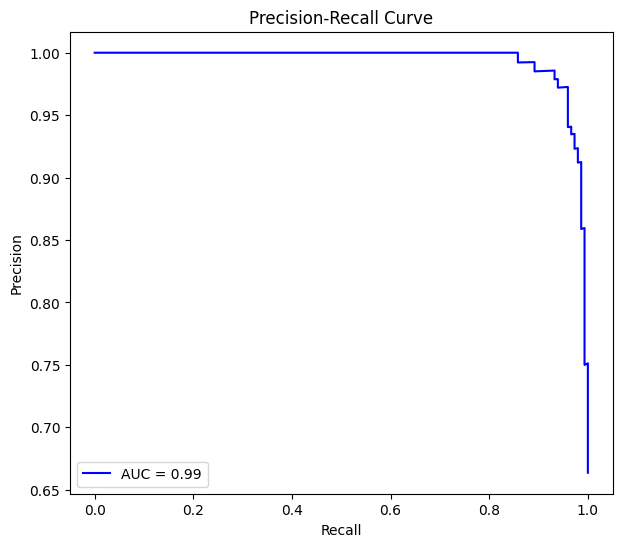

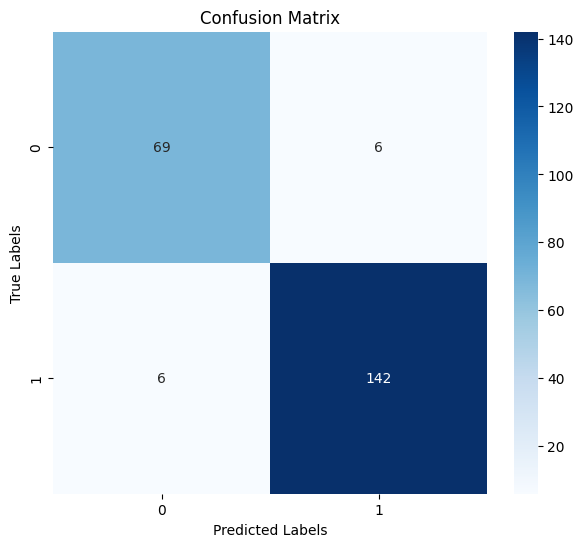

AUC for fold 4: 0.9889
Accuracy for fold 4: 0.9283



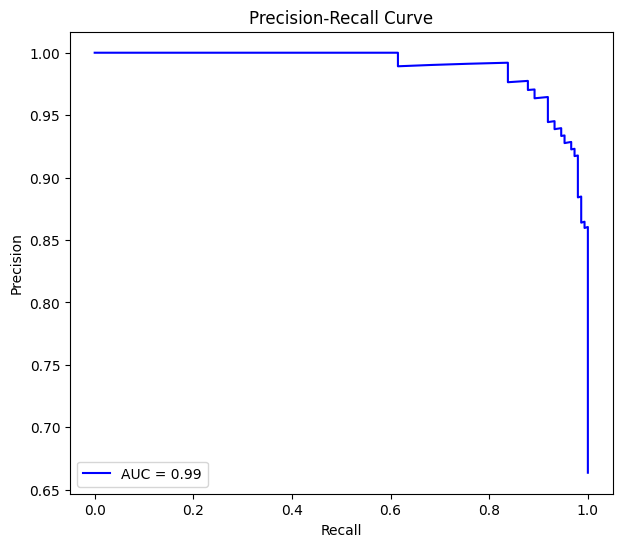

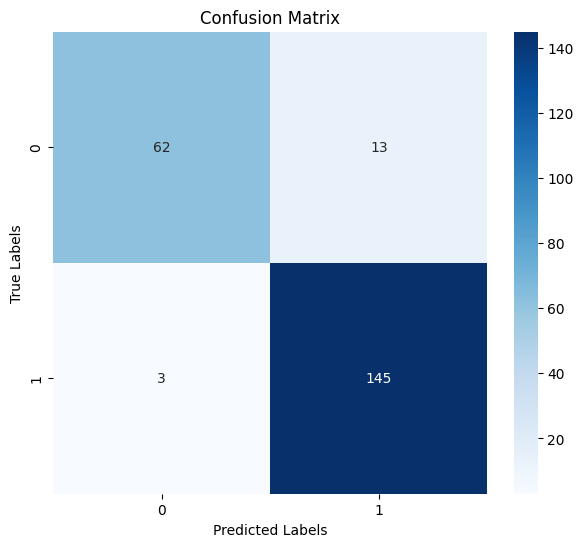

AUC for fold 5: 0.9765
Accuracy for fold 5: 0.9193



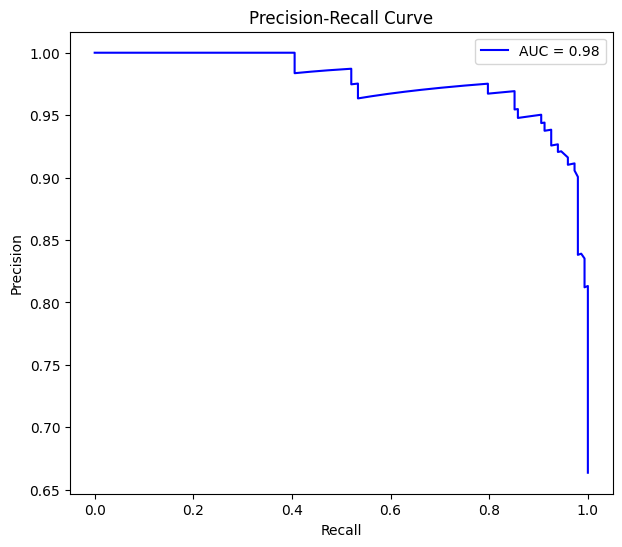

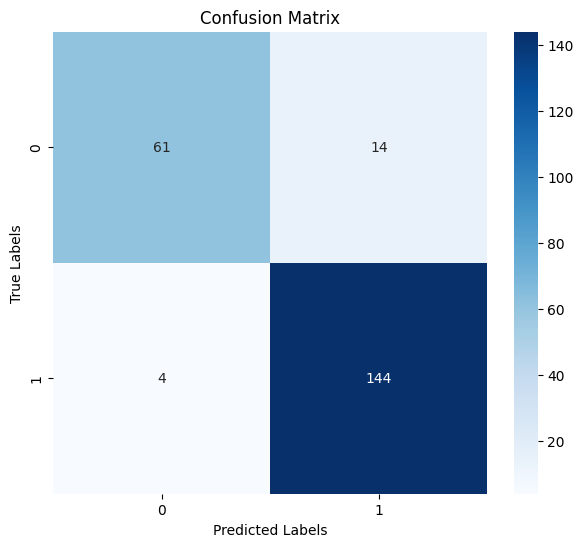

Mean AUC score: 0.98080
Mean accuracy score: 92.9148%


In [ ]:
xgboost = XGBClassifier(n_estimators=275, max_depth=6, scale_pos_weight=0.95, random_state=RANDOM_SEED, n_jobs=-1)
plots_stratified(X, y, xgboost)

### Best model

#### On the original data

In [33]:
# XGBoost, with original data (without remove useless features) -> the same results
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(xgboost, X_original, y_original, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.88340807 0.94618834 0.93273543 0.94618834 0.93273543]
Mean CV accuracy: 92.8251%


In [57]:
errors = [round(1-acc, 4) for acc in cv_scores]
errors

[0.1166, 0.0538, 0.0673, 0.0538, 0.0673]

In [58]:
mean_error = round(1-cv_scores.mean(), 4)
mean_error

0.0717

In [59]:
std_deviation = round(statistics.stdev(errors), 4)
std_deviation

0.026

In [ ]:
# XGBoost, F1 Score
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(xgboost, X_original, y_original, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.91333333 0.9602649  0.95049505 0.96       0.95145631]
Mean CV F1 score: 0.9471


In [ ]:
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)
auc_and_accuracy_scores(X_original, y_original, xgboost)

AUC for fold 1: 0.9708
Accuracy for fold 1: 0.9103

AUC for fold 2: 0.9822
Accuracy for fold 2: 0.9193

AUC for fold 3: 0.9861
Accuracy for fold 3: 0.9327

AUC for fold 4: 0.9856
Accuracy for fold 4: 0.9372

AUC for fold 5: 0.9887
Accuracy for fold 5: 0.9417

Mean AUC score: 0.98268
Mean accuracy score: 92.8251%


#### On the data without the useless features

In [ ]:
# XGBoost
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(xgboost, X, y, cv=5)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.88340807 0.94618834 0.93273543 0.94618834 0.93273543]
Mean CV accuracy: 92.8251%


In [ ]:
# XGBoost, F1 Score
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(xgboost, X, y, cv=5, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.91333333 0.9602649  0.95049505 0.96       0.95145631]
Mean CV F1 score: 0.9471


In [ ]:
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)
auc_and_accuracy_scores(X, y, xgboost)

AUC for fold 1: 0.9891
Accuracy for fold 1: 0.9327

AUC for fold 2: 0.9697
Accuracy for fold 2: 0.9103

AUC for fold 3: 0.9791
Accuracy for fold 3: 0.9013

AUC for fold 4: 0.9913
Accuracy for fold 4: 0.9462

AUC for fold 5: 0.9849
Accuracy for fold 5: 0.9507

Mean AUC score: 0.98283
Mean accuracy score: 92.8251%


#### On k_folds = 10

In [60]:
# XGBoost, with original data (without remove useless features) -> the same results
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
cv_scores = cross_val_score(xgboost, X_original, y_original, cv=10)

# Print the cross-validation scores
print("Cross-validation scores:", cv_scores)

# Print the mean cross-validation score
print(f"Mean CV accuracy: {cv_scores.mean() * 100:.4f}%")

Cross-validation scores: [0.90178571 0.86607143 0.94642857 0.9375     0.88392857 0.96396396
 0.94594595 0.90990991 0.89189189 0.96396396]
Mean CV accuracy: 92.1139%


In [61]:
errors = [round(1-acc, 4) for acc in cv_scores]
errors

[0.0982, 0.1339, 0.0536, 0.0625, 0.1161, 0.036, 0.0541, 0.0901, 0.1081, 0.036]

In [62]:
mean_error = round(1-cv_scores.mean(), 4)
mean_error

0.0789

In [63]:
std_deviation = round(statistics.stdev(errors), 4)
std_deviation

0.0349

In [31]:
# XGBoost, F1 Score
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Perform cross-validation with 5 folds
f1_scorer = make_scorer(f1_score)
cv_scores_f1 = cross_val_score(xgboost, X_original, y_original, cv=10, scoring=f1_scorer)

# Print the mean cross-validation score
print("Cross-validation F1 scores:", cv_scores_f1) # Score of 1 indicates perfect precision and recall
print(f"Mean CV F1 score: {cv_scores_f1.mean():.4f}")

Cross-validation F1 scores: [0.92517007 0.90066225 0.96       0.95364238 0.91503268 0.97368421
 0.96052632 0.93421053 0.92405063 0.97333333]
Mean CV F1 score: 0.9420


### Final Predictions with the best model

In [66]:
X_test_original.shape, y_original.shape

((124, 3473), (1115,))

In [67]:
X_test.shape

(124, 3276)

In [70]:
# XGBoost, best model
xgboost = XGBClassifier(n_estimators=275, max_depth=6, random_state=RANDOM_SEED, n_jobs=-1)

# Train the classifier on the whole dataset
xgboost.fit(X_original, y_original)

# Use the trained XGBoost classifier to make predictions and obtain probability scores on the test dataset
predictions = xgboost.predict(X_test_original)
prob_scores = xgboost.predict_proba(X_test_original)[:, 1]

# Create a DataFrame with both predictions and probabilities
result_df = pd.DataFrame({'Predictions': predictions, 'Probabilities': prob_scores})

# Save the DataFrame to a CSV file
result_df.to_csv('test_predictions.csv', index=False, header=False)

In [71]:
# Make predictions on the training data, very biased but just to check that the predictions are generated correctly
train_predictions = xgboost.predict(X_original)

# Calculate accuracy on the training data
accuracy = accuracy_score(y_original, train_predictions)

print(f'Accuracy on the training data: {accuracy*100:.4f}%')

Accuracy on the training data: 99.0135%
